# Police Fatal Shootings in US
Police brutality in the United States has been an nationwide issue since the 20th century. Public safety of U.S. citizens is a typical argument to justify the controversially high number of fatal shootings.

# Background and Goal

The goal of this report is to review the United States police shooting report from 2015 - 2021 to  provide a list of issues, and propose a plan on how to tackle the identified issues.


W -- White
B -- Black
H -- Hispanic
A -- Asian
O -- Other
N -- Native American

# Data Preprocessing

Install and import required packages

In [2]:
!pip install kmodes
!pip install shap
!pip install prince

     |████████████████████████████████| 358kB 26.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=5bd7b759d8330e0a476798ee1f8e479cbc412b8f567cefff6b7584a251297884
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import scipy.stats as st
from kmodes.kprototypes import KPrototypes
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import shap
import prince
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,silhouette_score, calinski_harabasz_score, classification_report, precision_score, recall_score, f1_score

In [4]:
dataset =pd.read_csv("https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv")

## Exploratory Data Analysis

In [5]:
dataset.isnull().sum()

id                           0
name                       233
date                         0
manner_of_death              0
armed                      207
age                        282
gender                       1
race                       636
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       414
body_camera                  0
longitude                  307
latitude                   307
is_geocoding_exact           0
dtype: int64

In [6]:
dataset = dataset.dropna(subset=['race', 'armed', 'age', 'flee', 'gender', 'latitude'])

In [7]:
dataset.isnull().sum()

id                         0
name                       9
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
dtype: int64

Splitting the date information into different columns

In [8]:
dataset['date']=pd.to_datetime(dataset['date'])
dataset['day'] = dataset['date'].dt.day
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

In [9]:
dataset['State_event_count'] = dataset['id'].groupby(dataset['state']).transform('count')

In [10]:
dataset = dataset.drop(axis=1, columns=['id'])

### Sign of Mental Illness
About 24% of the total observation population have mental health issues and most are predominately white race.
As observed below, 95% of the victims of police shootings are male. 

Text(0.5, 1.0, 'Signs of mental Illness Distribution')

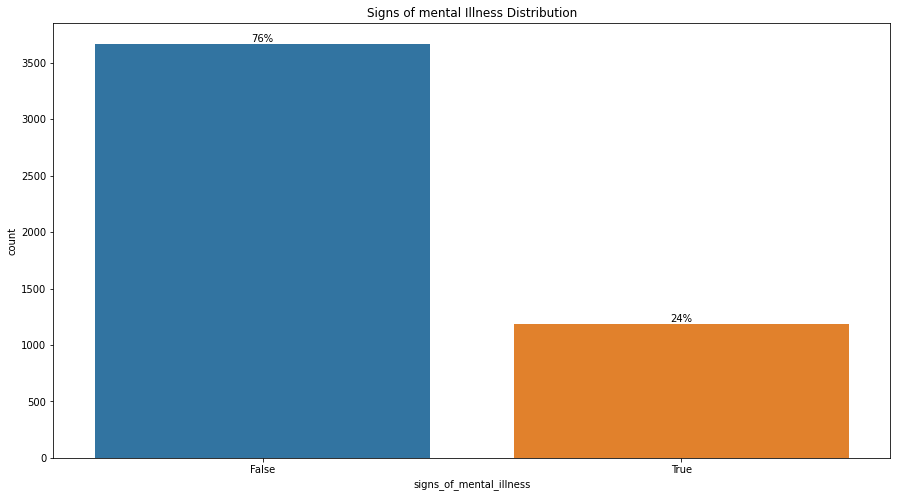

In [11]:
plt.figure(figsize=(15, 8))
g = sns.countplot(x="signs_of_mental_illness", data=dataset)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(dataset)), (x.mean(), y), ha='center', va='bottom')
g.set_title("Signs of mental Illness Distribution")

Text(0.5, 1.0, 'Mental illness distribution by race')

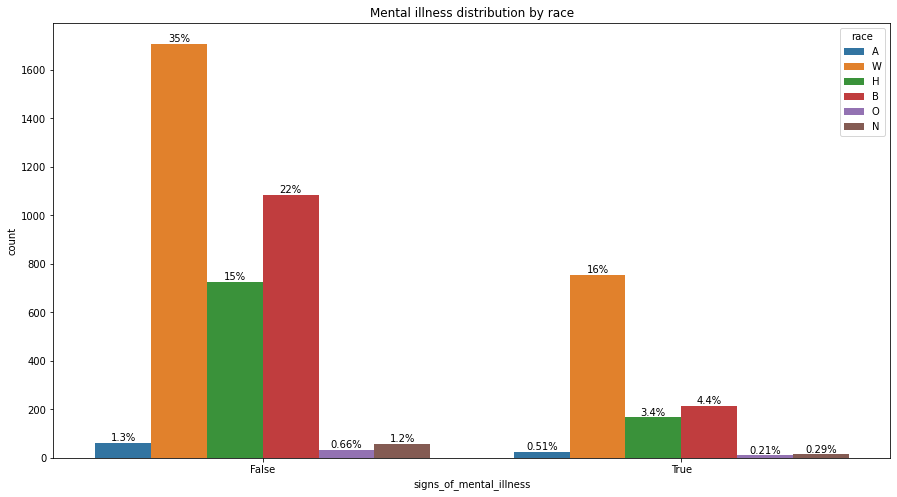

In [12]:
plt.figure(figsize=(15, 8))
g = sns.countplot(x="signs_of_mental_illness", hue="race", data=dataset)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(dataset)), (x.mean(), y), ha='center', va='bottom')
plt.title("Mental illness distribution by race")

Text(0.5, 1.0, 'Gender distribution of Mental illness')

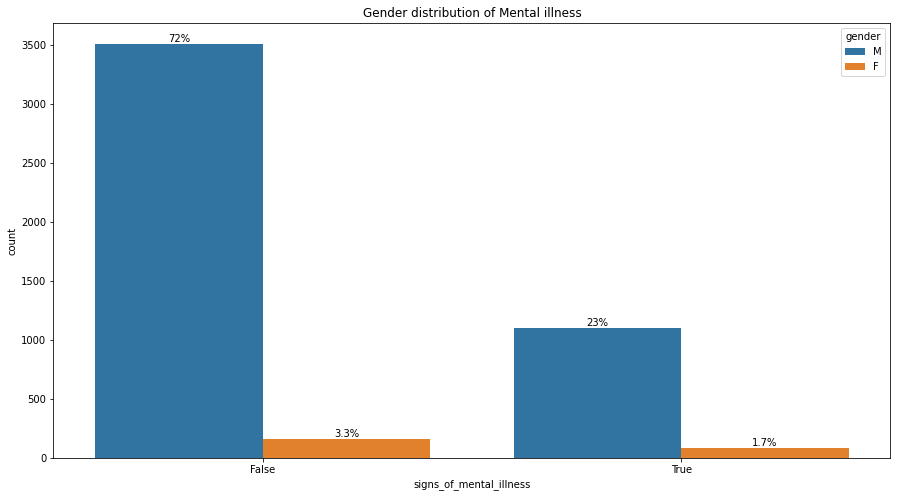

In [13]:
plt.figure(figsize=(15, 8))
g = sns.countplot(x="signs_of_mental_illness", hue="gender", data=dataset)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(dataset)), (x.mean(), y), ha='center', va='bottom')
plt.title("Gender distribution of Mental illness")

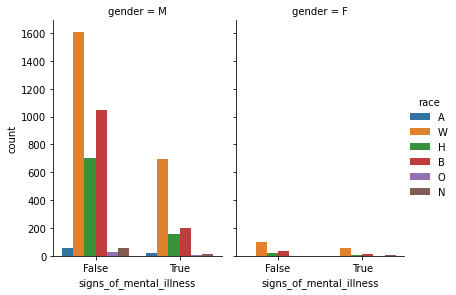

In [14]:
g = sns.catplot(x="signs_of_mental_illness", hue="race", col="gender",
                data=dataset, kind="count",
                height=4, aspect=.7)


### Age of victims

The victims of police shootings are averagely young adults between the ages of 20 and 40. Although few victims were below 20 and above 80

Text(0.5, 1.0, 'Age Distribution of police shooting victims')

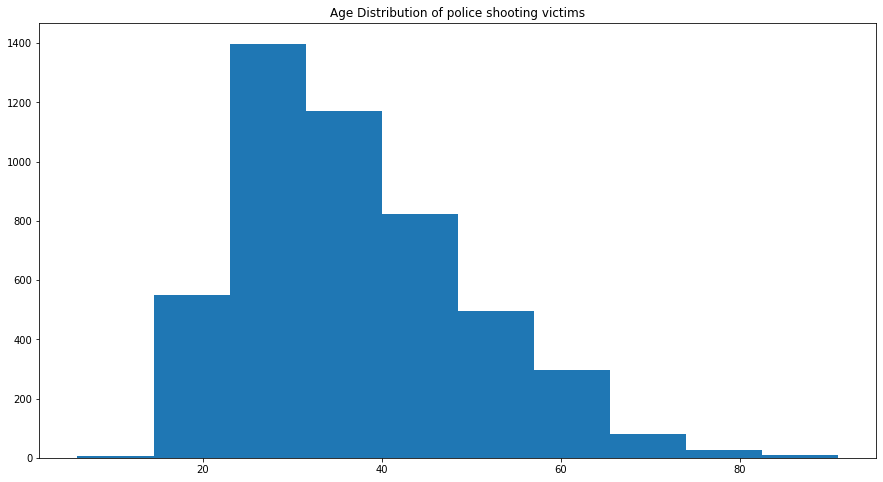

In [15]:
plt.figure(figsize=(15,8))
plt.hist(dataset['age'])
plt.title("Age Distribution of police shooting victims")

In [16]:
dataset.groupby('race')['age'].mean('age')

race
A    36.976744
B    32.597233
H    33.755879
N    32.535211
O    32.761905
W    40.079172
Name: age, dtype: float64

Text(0.5, 1.0, 'Killings Based on Age Separated by Race')

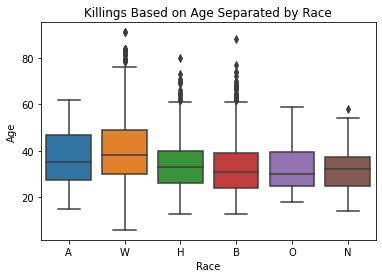

In [17]:
sns.boxplot(x='race', y='age', data=dataset)
plt.xlabel("Race")
plt.ylabel("Age")
plt.title("Killings Based on Age Separated by Race")

In [18]:
dataset[dataset['age'] < 18].groupby('age')['age'].count()

age
6.0      2
12.0     1
13.0     2
14.0     2
15.0    11
16.0    27
17.0    51
Name: age, dtype: int64

Text(0.5, 1.0, 'Minors distribution by race and armed')

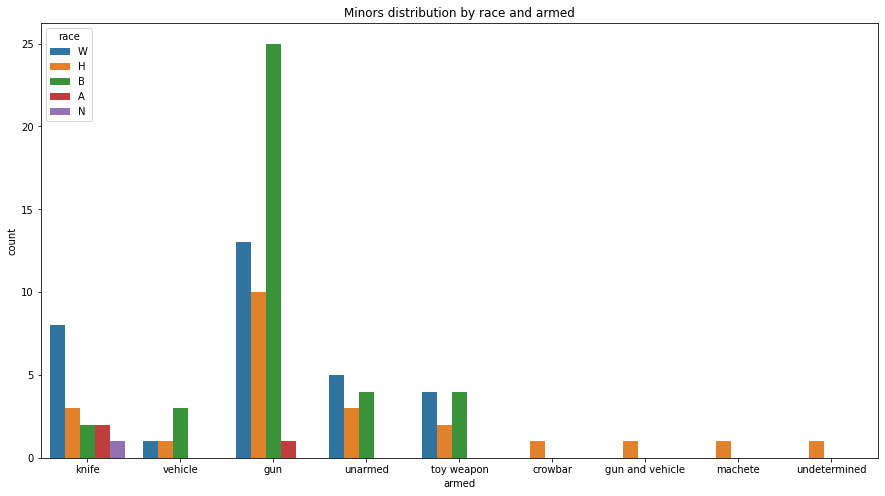

In [19]:
plt.figure(figsize=(15,8))
minor = dataset[dataset['age'] < 18]
sns.countplot(x="armed", hue="race", data=minor)
plt.title('Minors distribution by race and armed')

### Victims Fleeing

67% of the victims were not fleeing from the situation but most had weapons on them

Text(0.5, 1.0, 'Victims Fleeing Distribution')

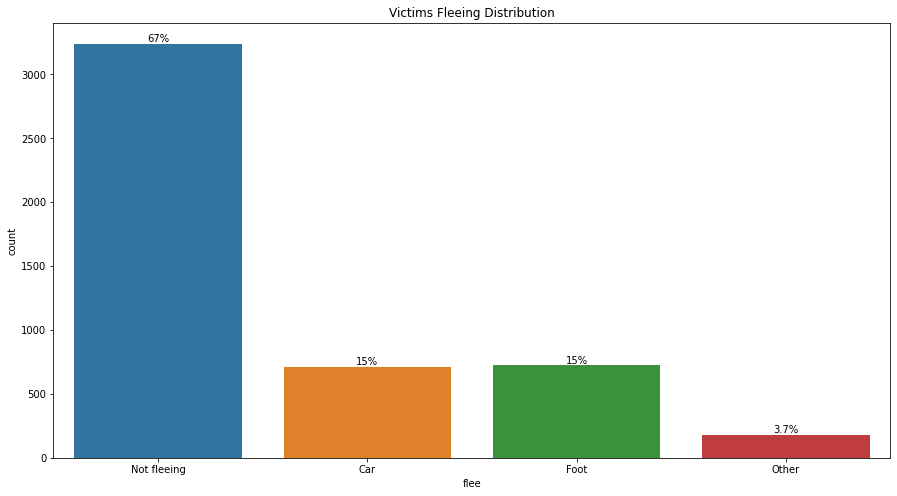

In [20]:
plt.figure(figsize=(15, 8))
g = sns.countplot(x="flee", data=dataset)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(dataset)), (x.mean(), y), ha='center', va='bottom')
g.set_title("Victims Fleeing Distribution")

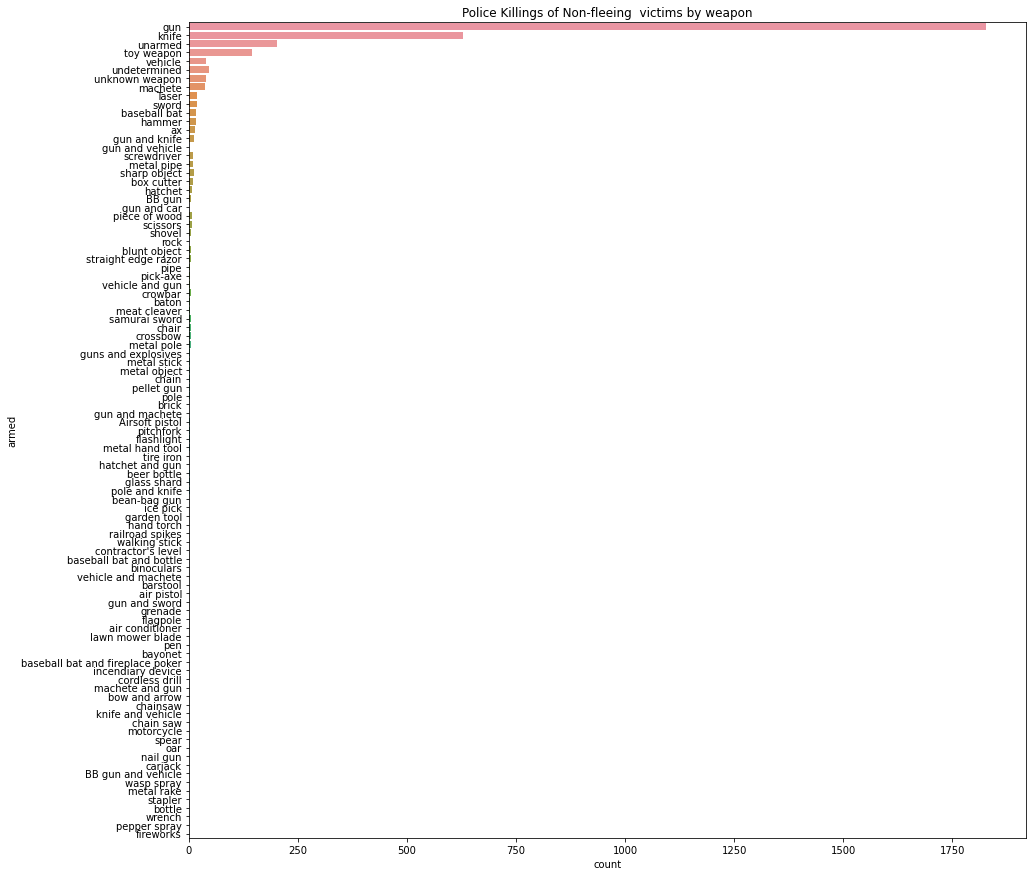

In [21]:
not_fleeing = dataset[dataset['flee'] == 'Not fleeing']
plt.figure(figsize=(15, 15))

sns.countplot(y="armed",data=not_fleeing,
              order=dataset.armed.value_counts().index)
plt.title('Police Killings of Non-fleeing  victims by weapon')
plt.show()

### Location of Event

Police Shootings happen across US. Califonia, Texas, Florida has the highest police shootings respectively. 
Most of Califonia's shootings happened in Los Angeles for consecutive years





In [22]:
data = dict(type='choropleth',
            locations = dataset['state'],
            locationmode = 'USA-states',
            colorscale = 'Picnic',
            text = dataset['state'],
            z = dataset['State_event_count'],
            colorbar = {'title':"Shooting incidence Count"}
            )
layout = dict(title = 'Police Shooting Distribution on US Map',geo = dict(scope='usa'))
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [23]:
data = go.Scattergeo(lon = dataset['longitude'],lat = dataset['latitude'],text = dataset['name'],mode = 'markers',
        marker = dict(symbol = 'star',size=5,colorscale = 'Reds'),marker_color = dataset['State_event_count'],)
layout = dict(title = 'Police Shooting locations in USA Map', geo_scope = 'usa')
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

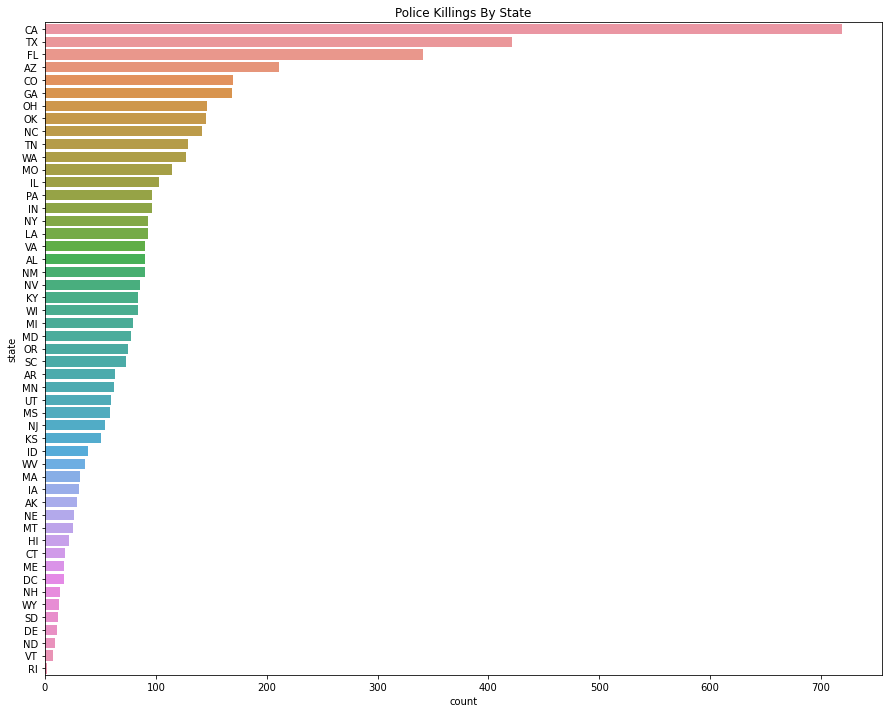

In [24]:
plt.figure(figsize=(15, 12))

sns.countplot(y="state",data=dataset,
              order=dataset.state.value_counts().index)
plt.title('Police Killings By State')
plt.show()

In [25]:
CA_shootings = dataset[dataset['state'] == 'CA'].groupby(['year','city']).agg({'armed':'count'}).sort_values(by='armed', ascending = False).reset_index().head(10)
CA_shootings

,year,city,armed
0,2019,Los Angeles,15
1,2016,Los Angeles,14
2,2015,Los Angeles,13
3,2017,Los Angeles,13
4,2020,Los Angeles,9
5,2018,Los Angeles,7
6,2015,Oakland,6
7,2015,Fresno,6
8,2015,Bakersfield,6
9,2015,San Francisco,6


### Date distribution of Shootings

It can be seen that the rate of police shooting is steady across years, although killings is higher on Tuesdays - Thursdays as compared to other days

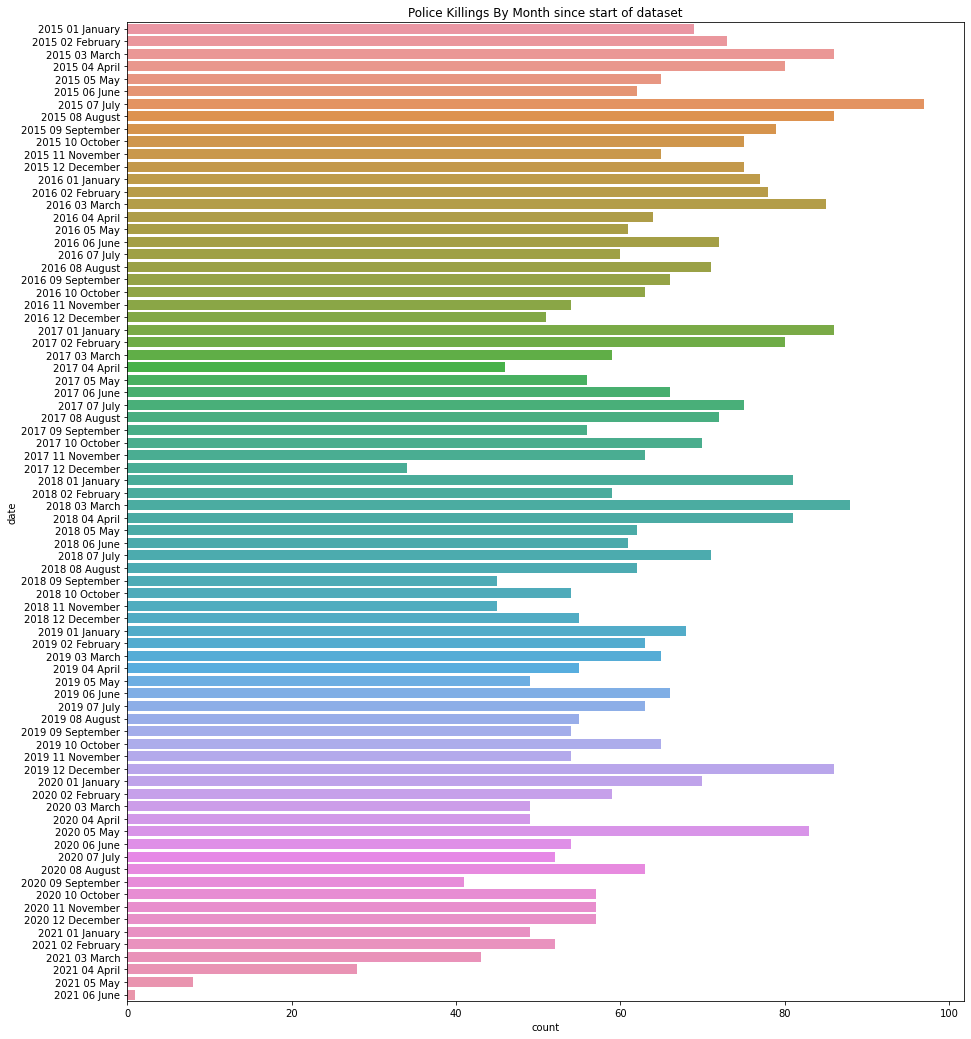

In [26]:
plt.figure(figsize=(15,18))
sns.countplot(y=dataset.date.dt.strftime('%Y %m %B'), 
              order=sorted(dataset.date.dt.strftime('%Y %m %B').unique()))
plt.title('Police Killings By Month since start of dataset')
plt.show()

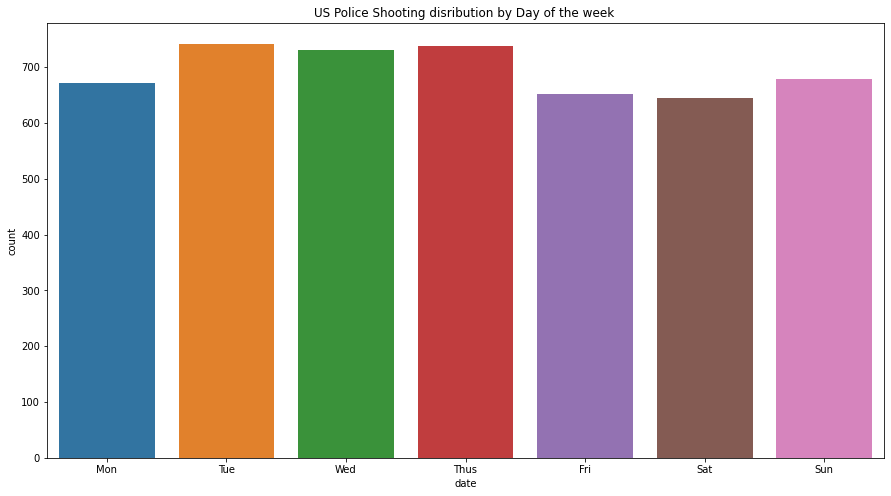

In [27]:
days={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thus', 4:'Fri', 5:'Sat', 6:'Sun'}

plt.figure(figsize=(15,8))

sns.countplot(x=dataset.date.dt.dayofweek.map(days), order=days.values())
plt.title('US Police Shooting disribution by Day of the week ')
plt.show()

### Police Shootings in wrt Population

Based on 2019 population estimates, male and female population in the US was 49.2% 50.8% respectively. 
Using the US census population information with shootings dataset, it shows that Blacks are killed at a higher proportion. There is a high rate on Black killings

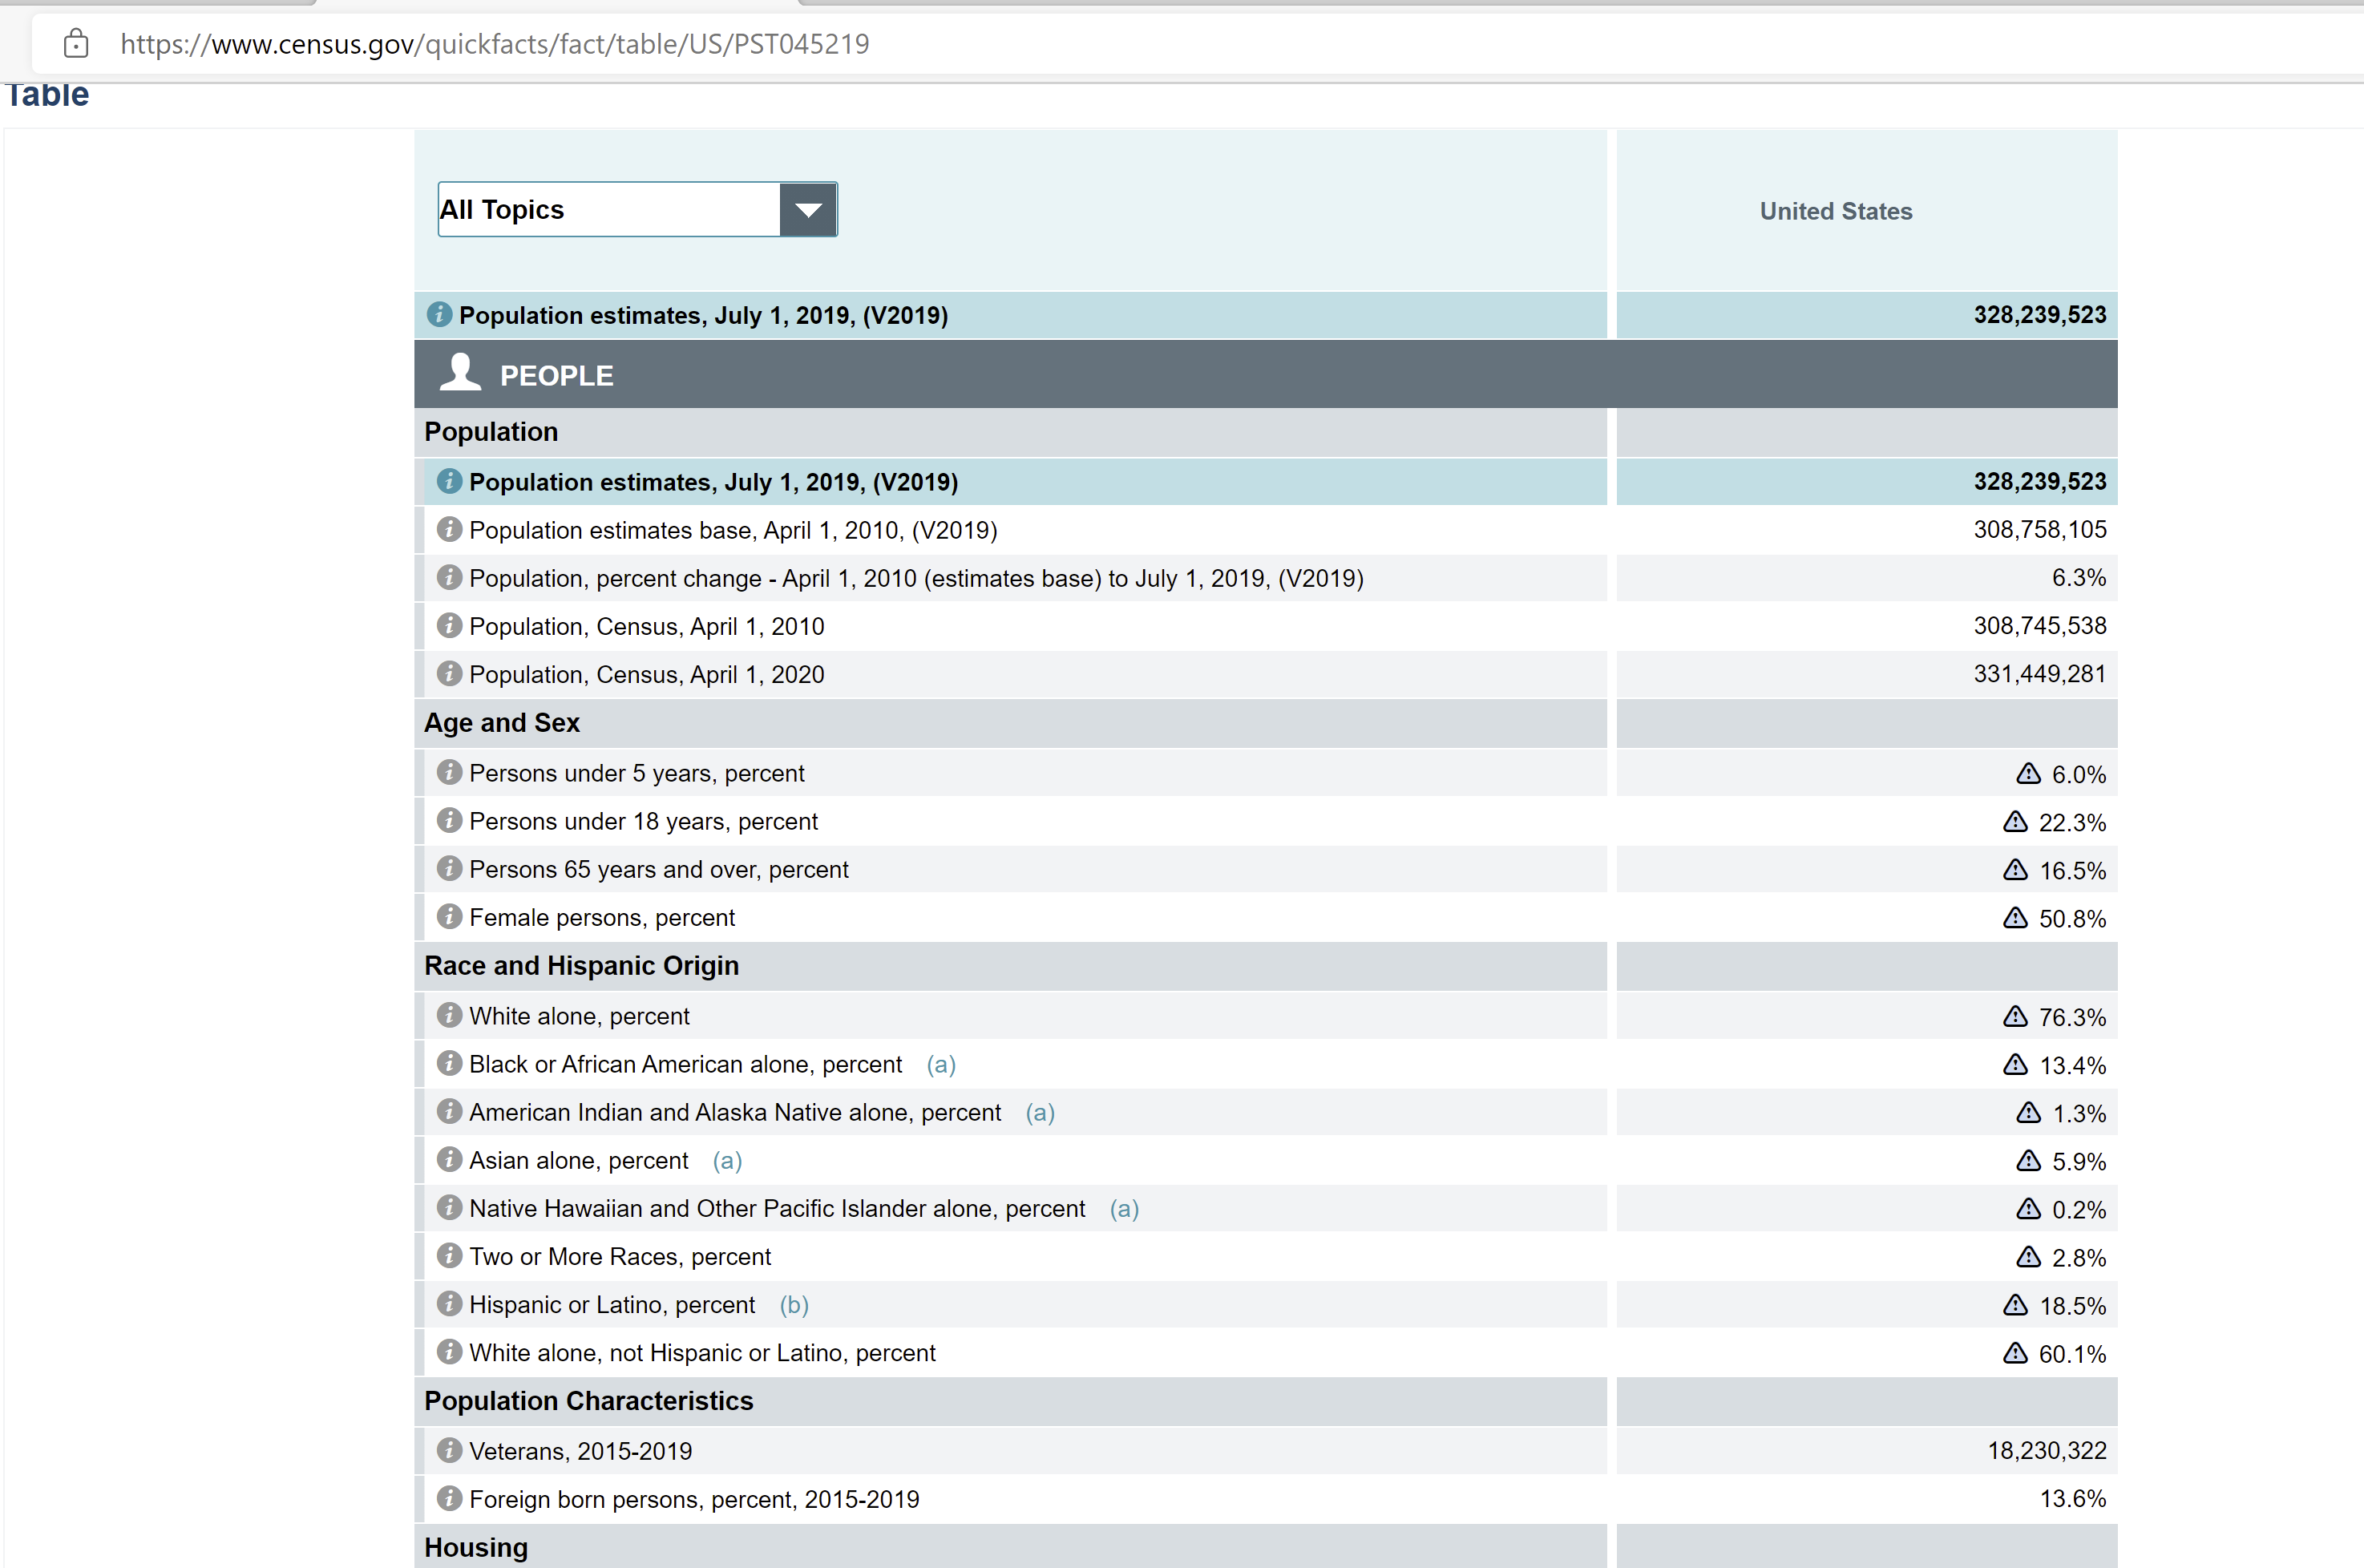

In [28]:
population_race={'W':60.1, 'B':13.4, 'N':1.5, 'A':5.9, 'H':18.5, 'O':0.6}
def populationdist(df, pop, group):
    
    d = {group: [], 'set': [], '%val': []}
    tot_pop = float(sum(pop.values()))
    for col in df[group].dropna().unique():
        d[group].append(col)
        d['set'].append('Police Shootings')
        d['%val'].append(100*df[df[group]==col].name.count()/df.name.count())
        d[group].append(col)
        d['set'].append('US Population')
        d['%val'].append(pop[col])
        
    return pd.DataFrame(data=d)

In [29]:
population_race = populationdist(dataset, population_race, 'race')

Text(0.5, 1.0, 'US Police shooting vs Population by race ')

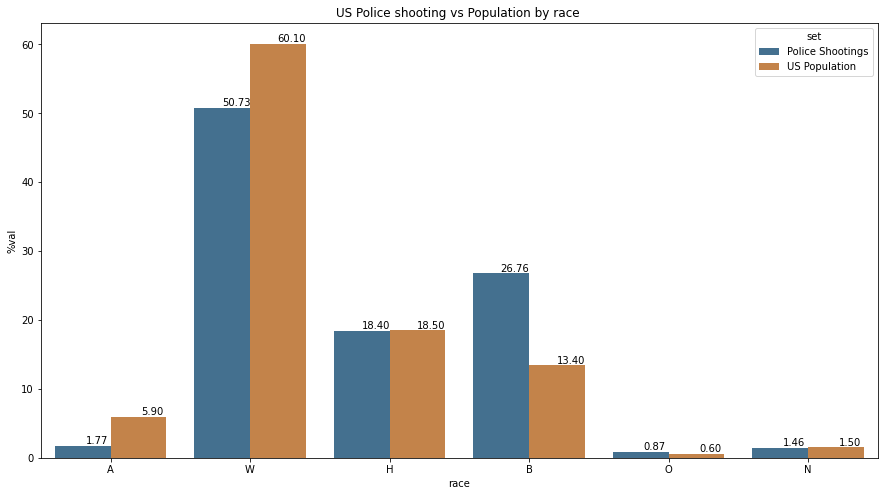

In [30]:
plt.figure(figsize=(15, 8))
g = sns.barplot(x="race", hue="set", y= "%val", data=population_race,saturation=.5)

for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
g.set_title('US Police shooting vs Population by race ')

#### Statistics Hypothesis of Police Shootings in wrt to Population

##### Are shooting down in 2020 from previous year?
 - H0 : 2019 police shooting = 2020 police shooting
 - H1 : 2019 police shooting != 2020 police shooting

 using  5% alpha level, confidene level = 95%

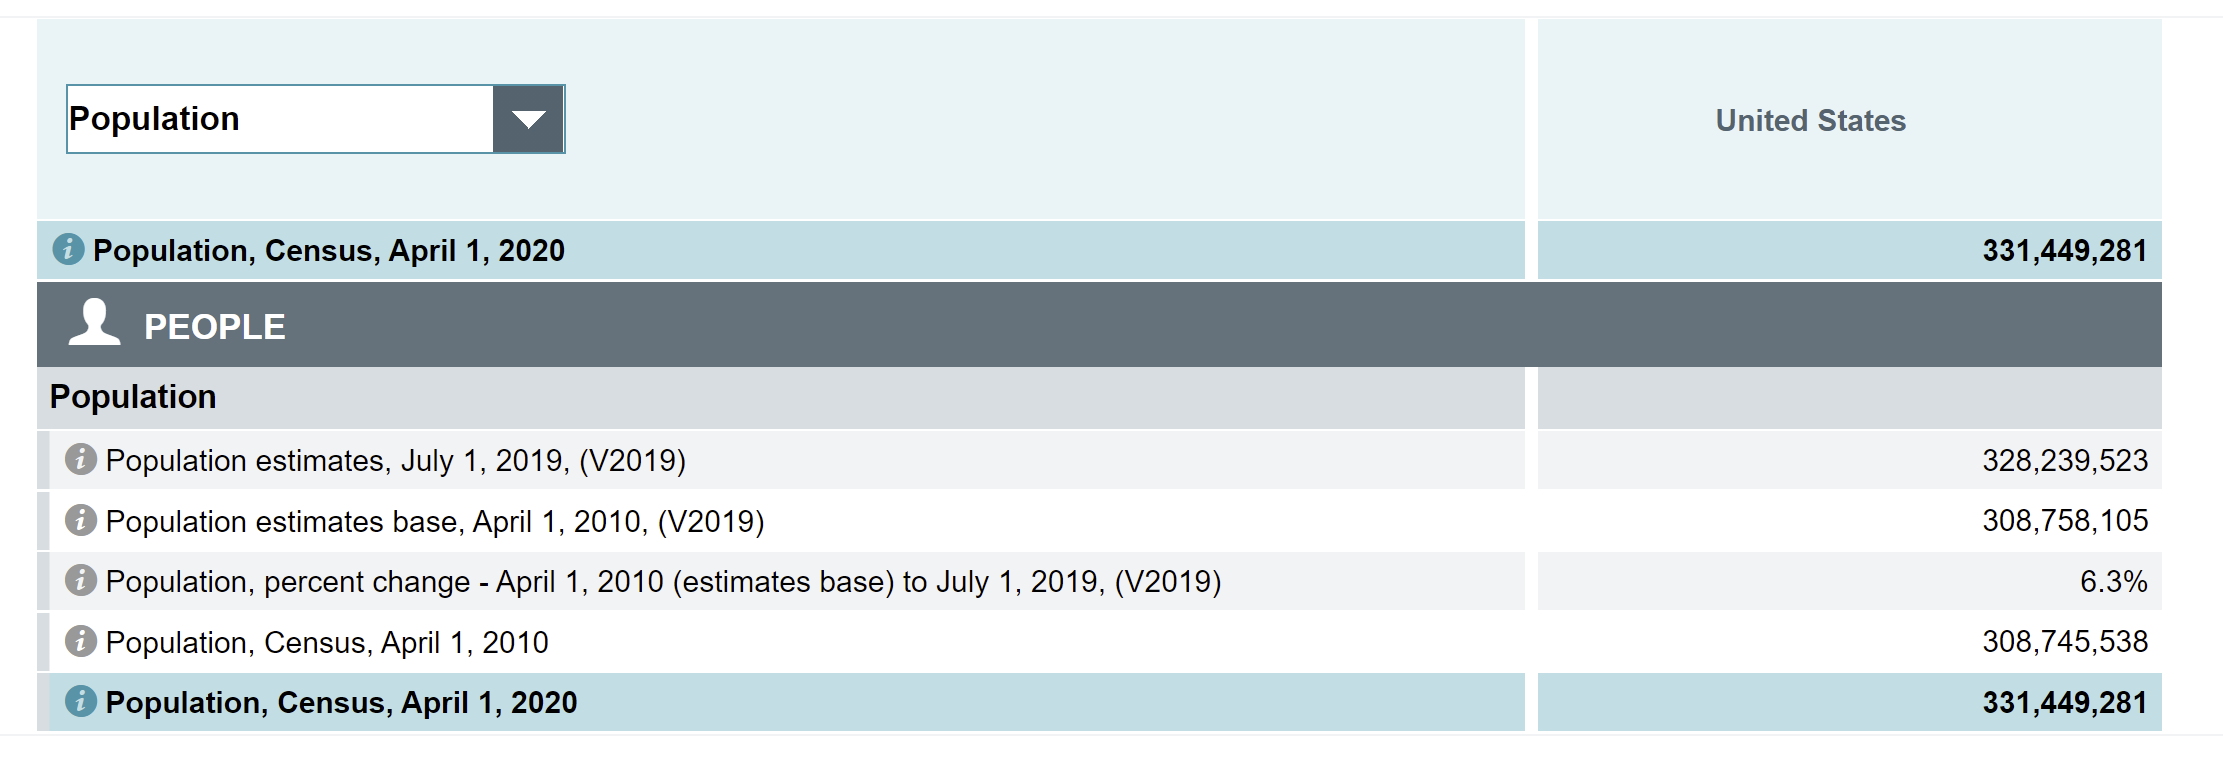

Text(0.5, 1.0, 'Police Shooting Year Distribution')

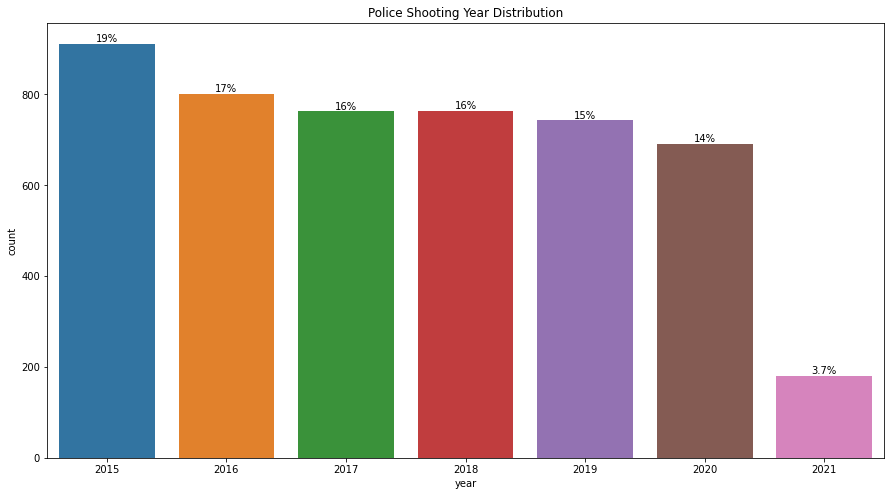

In [31]:
plt.figure(figsize=(15, 8))
g = sns.countplot(x="year", data=dataset)
for p in g.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  g.annotate('{:.2g}%'.format(100.*y/len(dataset)), (x.mean(), y), ha='center', va='bottom')
g.set_title("Police Shooting Year Distribution")

In [32]:
def hypothesis_statistics(s1, s2,  p1, p2, alpha):
  P1  = s1/p1
  P2 = s2/p2
  p = (s1 + s2)/(p1 +p2)
  Z = (P1 - P2)/math.sqrt(p * (1-p)* ((1/p1)+(1/p2)))
  alp = st.norm.ppf(1 - (alpha/2))

  if Z < alp:
    return f"{Z} Test does not fall in rejection region, Accept H0"
  else:
    return f"{Z} Test falls within rejection region, reject H0"


In [33]:
total_2019 = dataset.loc[(dataset['year'] == 2019)].shape[0]
total_2020 = dataset.loc[(dataset['year'] == 2020)].shape[0]

In [34]:
p_2020 = 331449281
p_2019 = 328329523

In [35]:
hypothesis_statistics(total_2019,total_2020,p_2019,p_2020,0.05)

'1.5522625454212655 Test does not fall in rejection region, Accept H0'

Since the calculated z-statistics of 1.55 which is less than significance level 0.05, we accept the null hypothesis and conclude that there is no difference in 2019 and 2020 police shootings

##### Is there racial bias between black and white shooting?
 - H0 : 2020 White Shooting = 2020 Black Shooting
 - H1 : 2020 White Shooting != 2020 Black Shooting

 using  5% alpha level, confidene level = 95%

 using 2020 population count and 60.1% and 13.4% white and black population percent respectively as given on US census site.

In [36]:
pop_W = round(p_2020 * 0.601)
pop_B = round(p_2020 * 0.134)

In [37]:
p_B = dataset.loc[(dataset['year'] == 2020) & (dataset['race'] == 'B')].shape[0]
p_W = dataset.loc[(dataset['year'] == 2020) & (dataset['race'] == 'W')].shape[0]

In [38]:
hypothesis_statistics(p_B,p_W,pop_B,pop_W,0.05)

'10.893231448286452 Test falls within rejection region, reject H0'

Since the calculated z-statistics of 10.89 which is greater than significance level 0.05, we reject the null hypothesis and conclude that there is significant difference between White Shooting and Black Shooting by the police in US

# Modelling

In [39]:
dataset_cat = dataset[['manner_of_death','armed','gender','race', 'city','state','signs_of_mental_illness','threat_level','flee','body_camera','is_geocoding_exact']]
dataset_num = dataset[['age','longitude','latitude','day','month','year']]

In [40]:
cat_cols = [0,1,2,3,4,5,6,7,8,9,10]
dataset_ = pd.concat([dataset_cat, dataset_num], axis = 1)

### Dimension Reduction

Prince Library - factor analysis of mixed data will be used for Factor Analysis since the dataset has both  categorical and numerical variables

In [41]:
dataset_["signs_of_mental_illness"] = dataset_["signs_of_mental_illness"].astype(int)
dataset_["body_camera"] = dataset_["body_camera"].astype(int)
dataset_["is_geocoding_exact"] = dataset_["is_geocoding_exact"].astype(int)

In [42]:
famd = prince.FAMD(n_components=2,n_iter=100,copy=True,check_input=True,engine='auto', random_state=42)
famd = famd.fit(dataset_)
famd_dt = famd.row_coordinates(dataset_)

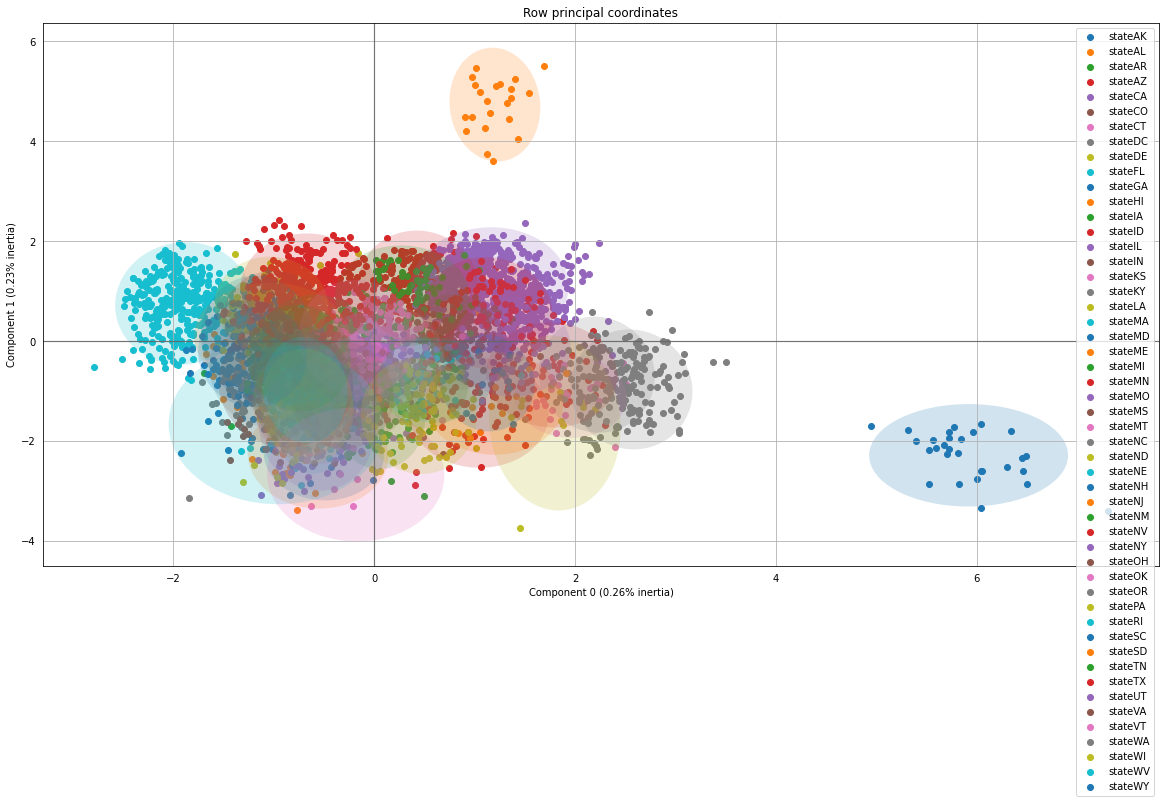

In [43]:
ax = famd.plot_row_coordinates(dataset_,ax=None,figsize=(20, 10),x_component=0,y_component=1,
color_labels=['state{}'.format(t) for t in dataset_['state']],
ellipse_outline=False,
ellipse_fill=True,
show_points=True)

### Clustering on Dimension Reduction Features with KMeans

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

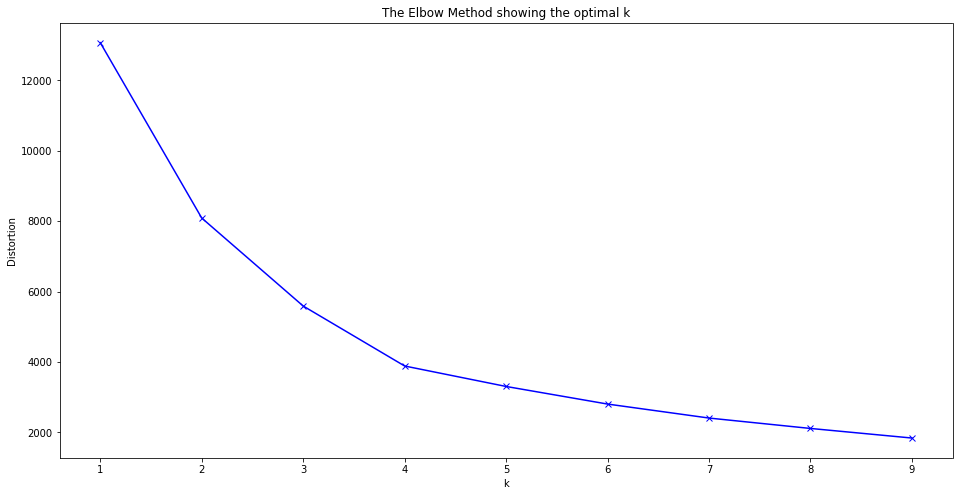

In [44]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(famd_dt)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [45]:
km = KMeans(n_clusters=4,init='k-means++', random_state=42)
km.fit(famd_dt)
labels_km = km.labels_
famd_km = km.predict(famd_dt)

cluster_km = pd.DataFrame(famd_km)
cluster_km.columns = ['Predicted_cluster_DR']
famd_dt.reset_index()
dataset_km = pd.concat([famd_dt, cluster_km], axis=1).reset_index()
dataset_km= dataset_km.drop(['index'], axis = 1)


In [46]:
def cluster_accuracy(data, pred_data):
  sil = silhouette_score(data, pred_data, metric='euclidean')
  cal = calinski_harabasz_score(data, pred_data)

  return sil, cal

cluster_accuracy(famd_dt, famd_km)

(0.42651979791542666, 3827.2521133811883)

## Clustering mixed police shooting Dataset with K-Prototype

In [ ]:
cost = []
for num_clusters in list(range(1,14)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(dataset_, categorical=cat_cols)
    cost.append(kproto.cost_)
    
plt.plot(cost)

In [ ]:

kproto_ = KPrototypes(n_clusters=4, init='Cao', n_init = 1, verbose=1)
kproto_.fit(dataset_, categorical=cat_cols)
clusters_ = kproto_.predict(dataset_, categorical=cat_cols)

In [ ]:
pd.Series(clusters_).value_counts()

In [ ]:
print(kproto_.cluster_centroids_)
print(kproto_.cost_)
print(kproto_.n_iter_)

In [ ]:
clusterdf = pd.DataFrame(clusters_)
clusterdf.columns = ['Predicted_cluster']
dataset_cl = pd.concat([dataset_, clusterdf], axis = 1).reset_index()
dataset_cl= dataset_cl.drop(['index'], axis = 1)

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dataset_cl['race'],order=dataset_cl['race'].value_counts().index,hue=dataset_cl['Predicted_cluster'])
plt.show()

To show that K-Prototype algorithm works, the clusters generated using K-prototype will be treated as target values and a classification modelling will be done.

SHAP (SHapley Additive exPlanations) a unified approach to explain the output of any machine learning model, is used to determine the distinctiveness of the clusters

In [ ]:
lgbm_data = dataset_.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [ ]:
clf_kp = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters_, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

In [ ]:
clf_kp.fit(lgbm_data, clusters_)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

Conclusion:

From the Hypothesis testing and EDA, it was discovered that


1.   There is no difference between shootings in 2019 and 2020. 
2.   There is a significant difference between police shootings involving White and Black
1.   The youths are largely affected by the shootings, although some minors are involved
2.   The victims are predominately male eve though females have a larger population 
1.   Large States tends to have higher shootings count
2.   Police shootings is steady across dates. The dataset didnt show peak periods
1.   24% of victims have mental health issues
2.   67% of the victims were not fleeing from the scene, but most had weapons on them


Recommendation:
1.   Since most victims are between the ages of 20 and 40 and are predominately male, special programs targetted towards care, mentorship and responsibilities can be introduced in school curriculum. This is geared towards reducing crimes amongst males
2.   Collection of more information to the dataset will also help in deducing issues and recommending solutions. informations like - family background, education etc







